# Interactive Plot to compare leaf contours and their feature space distances 
- Loads PCA model and dataset of leaf point clouds
- Creates two contour plots for comparison
- Use the textboxes to filter which leaf instances are shown (plant numbers, timesteps, or specific leaf numbers)
- Also plots a confusion matrix of the feature space distances between each instance pair


In [1]:
import leaf_encoding
import visualise
import leaf_matching
import packages.pheno4d_util as putil

%matplotlib notebook
from ipywidgets import *
import numpy as np
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Load data

In [61]:
directory = os.path.join('/home', 'karolineheiwolt','workspace', 'data', 'Pheno4D', '_processed', 'pca_input')
PCAH, test_ds, test_labels = leaf_encoding.get_encoding(train_split=0, directory=directory, standardise=True,  \
                            location=True, rotation=True, scale=True, as_features=False)
data = PCAH.training_data
labels = PCAH.training_labels

In [62]:
IDs = [0,3,None,None,0,4,None,None] # Plant, timestep, day, leafnr
annotations = 3 # 0 for plant number, 1 for timestep, 2 for day, 3 for leaf number

<IPython.core.display.Javascript object>


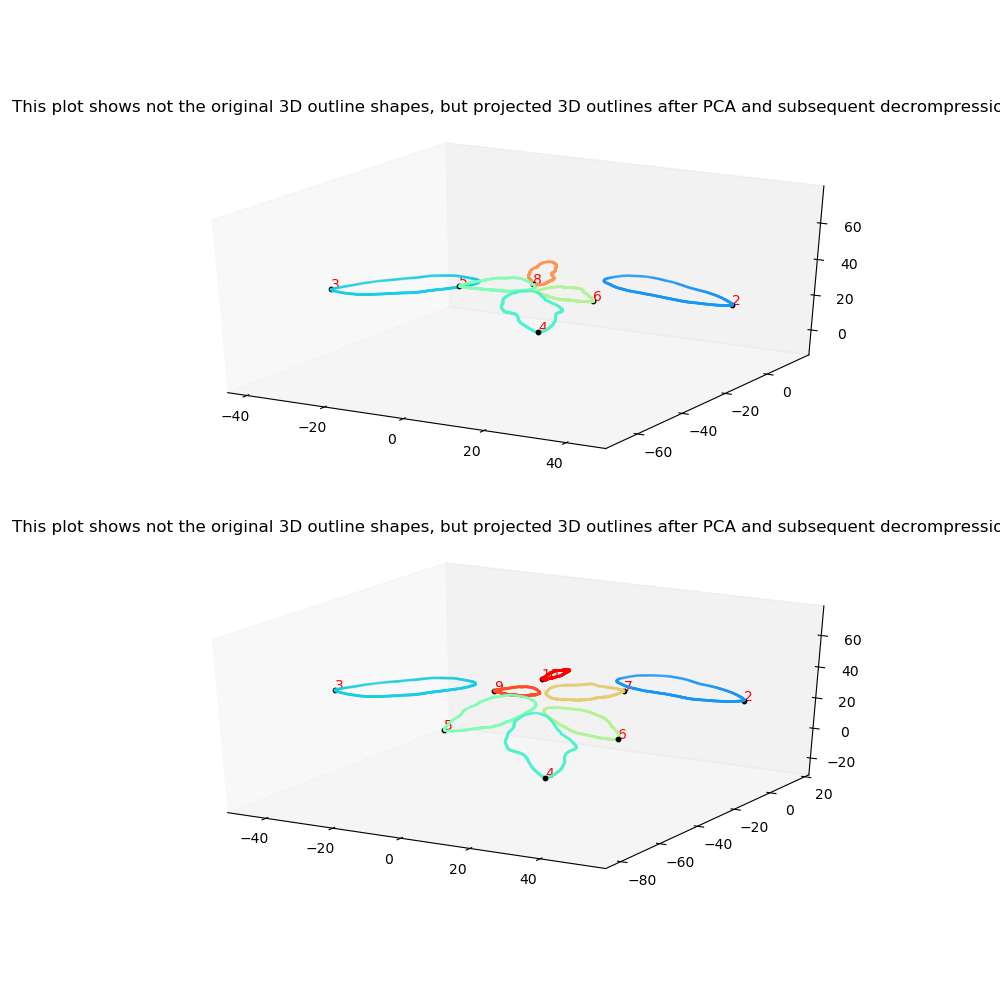

<IPython.core.display.Javascript object>


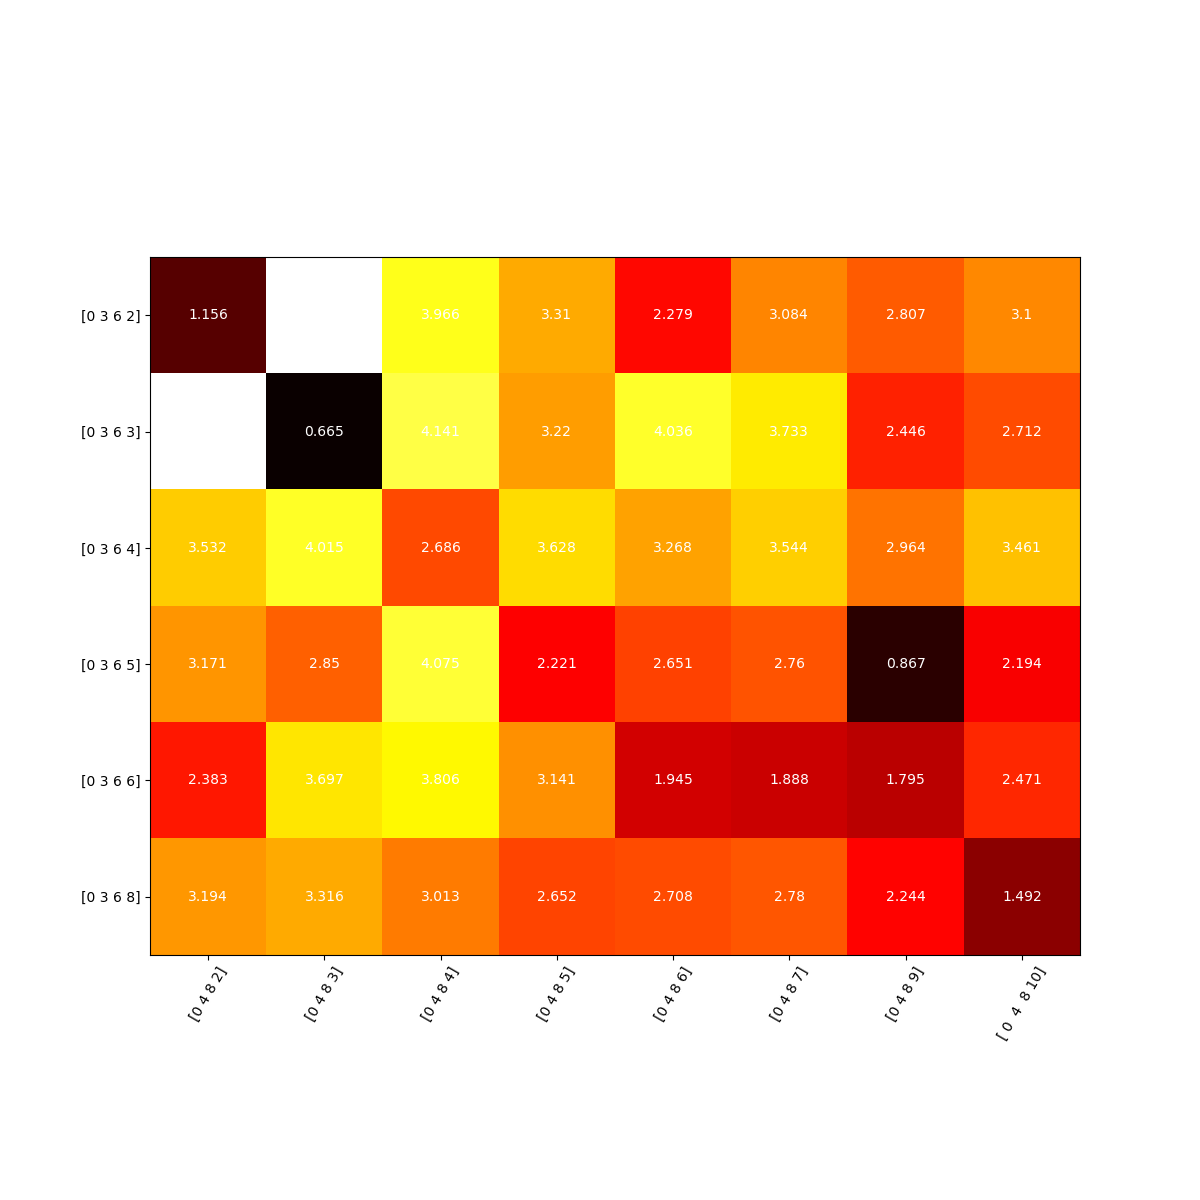

interactive(children=(Checkbox(value=True, description='box1'), BoundedIntText(value=0, description='Plant Num…

<function __main__.update(box1, plant, box2, timestep, box3, day, box4, leaf, box5, plant2, box6, timestep2, box7, day2, box8, leaf2)>

In [63]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(2, 1, 1, projection='3d')
ax2 = fig.add_subplot(2, 1, 2, projection='3d')
fig2 = plt.figure(figsize=(12, 12))
ax3 = fig2.add_subplot(1, 1, 1)
ax_3d = [ax,ax2]

def update(box1, plant, box2, timestep, box3, day, box4, leaf, box5, plant2, box6, timestep2, box7, day2, box8, leaf2):
    toggles = [(box1, box2, box3, box4), (box5, box6, box7, box8)]
    parameters = [(plant, timestep, day, leaf), (plant2, timestep2, day2, leaf2)]
    components = 22
    IDs = [[None if box == False else params[i] for i,box in enumerate(toggle)]for params,toggle in zip(parameters, toggles)]

    datasets = []
    for ID in IDs:
        subset, sub_labels = leaf_encoding.select_subset(data, labels, plant_nr = ID[0], timestep=ID[1], day=ID[2], leaf=ID[3])
        datasets.append((subset,sub_labels))
        if subset.size == 0:
            print('WARNING: One of your selected subsets is empty!')
            break

    max_color = np.max((np.max(datasets[0][1][:,3]), np.max(datasets[1][1][:,3])))
    cmap = cm.get_cmap('rainbow')
    
    data_copy = copy.deepcopy(datasets)

    offset = False
    show_decompressed = True
    for subset, ax in zip(data_copy, ax_3d):
        ax.clear()
        ax.grid(False)
        #ax.axis('off')
        colours = cmap((subset[1][:,3]/max_color))
        cum_offset = 0
        width = 0
        for leaf,label,col in zip(subset[0],subset[1],colours):
            
            if show_decompressed:
                ax.title.set_text('This plot shows not the original 3D outline shapes, but projected 3D outlines after PCA and subsequent decrompression')
                weights = PCAH.compress(leaf, components)
                reprojection = PCAH.decompress(weights, components) # shape (1xfeatures)
                decompressed_outline, add_f = leaf_encoding.reshape_coordinates_and_additional_features(reprojection)
                outline = np.squeeze(decompressed_outline) # Remove extra dimension 1x500x3 to 500x3
            else:
                outline = leaf_encoding.reshape_coordinates_and_additional_features(leaf)[0] # 500x3
            
            if offset:
                cum_offset += 0.6 * width
                width = (np.max(outline[:,0]) - np.min(outline[:,0]))
                cum_offset += 0.6 * width
                outline[:,0] += cum_offset
            scatterplot = ax.scatter(xs=outline[:,0], ys=outline[:,1], zs=outline[:,2], s=1, color=col)
            start_point = ax.scatter(xs=outline[0][0], ys=outline[0][1], zs=outline[0][2], s=10, color='black')
            out = ax.text(outline[0,0], outline[0,1], outline[0,2], s=str(label[annotations]), color='red')
        visualise.set_axes_equal(ax)
        
    ax3.clear()
    dist = leaf_matching.make_fs_dist_matrix(datasets[0][0], datasets[1][0], PCAH, mahalanobis_dist = True, draw=False, components=components)
    heatplot = leaf_matching.plot_heatmap(dist, ax=ax3, show_values=True)
    out = heatplot.set_xticks(range(datasets[1][1][:].shape[0]))
    out = heatplot.set_yticks(range(datasets[0][1][:].shape[0]))
    out = heatplot.set_xticklabels(datasets[1][1][:], rotation = 60)
    out = heatplot.set_yticklabels(datasets[0][1][:])
    
    # get assignment via  Hungarian Algorithm
    match, legible_matches = leaf_matching.compute_assignment(dist, datasets[0][1], datasets[1][1])
    print(legible_matches)
    
    
    fig.canvas.draw_idle()
    fig2.canvas.draw_idle()

interact(update, \
         box1 = widgets.Checkbox(value=True), \
         plant = widgets.BoundedIntText(value=None, min=0, max=6, step=1, description='Plant Number'), \
         box2 = widgets.Checkbox(value=True), \
         timestep = widgets.BoundedIntText(value=3, min=0, max=10, step=1, description='Time step'), \
         box3 = widgets.Checkbox(value=False), \
         day = widgets.BoundedIntText(value=None, min=0, max=20, step=1, description='Day Number'), \
         box4 = widgets.Checkbox(value=False), \
         leaf = widgets.BoundedIntText(value=None, min=2, max=40, step=1, description='Leaf number'), \
         box5 = widgets.Checkbox(value=True), \
         plant2 = widgets.BoundedIntText(value=None, min=0, max=6, step=1, description='Plant Number'), \
         box6 = widgets.Checkbox(value=True), \
         timestep2 = widgets.BoundedIntText(value=4, min=0, max=10, step=1, description='Time step'), \
         box7 = widgets.Checkbox(value=False), \
         day2 = widgets.BoundedIntText(value=None, min=0, max=20, step=1, description='Day Number'), \
         box8 = widgets.Checkbox(value=False), \
         leaf2 = widgets.BoundedIntText(value=None, min=2, max=40, step=1, description='Leaf number'))

